### 将 需要抽帧的样例视频 从 S3 中复制文件到 Notebook 本地
如果视频不大，也可以直接从本地上传到notebook的video文件夹下

In [14]:
import boto3
s3client = boto3.client("s3")
response = s3client.download_file('search-bike', 'videoToFrames01.mp4', './video/videoToFrames01.mp4')

### 定义抽帧需要的方法

In [112]:
import cv2
import argparse
import json
import os
import numpy as np
import errno
from datetime import datetime


def getVideoInfo(sourcePath):
    cap = cv2.VideoCapture(sourcePath)
    if not cap.isOpened():
        return None
    info = {
        "framecount": cap.get(cv2.CAP_PROP_FRAME_COUNT),
        "fps": cap.get(cv2.CAP_PROP_FPS),
        "width": int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        "heigth": int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        "codec": int(cap.get(cv2.CAP_PROP_FOURCC))
    }
    if info["fps"] != 0:
        info["seconds"] = int(info["framecount"] / info["fps"])
    cap.release()
    return info


def scale(img, xScale, yScale):
    res = cv2.resize(img, None, fx=xScale, fy=yScale, interpolation= cv2.INTER_AREA)
    return res

# 生成低分辨率灰度图 用于比较帧之间的差异
def createGrayThumbnail(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)      # 提取灰度信息
    gray = scale(gray, 0.125, 0.125)      # 缩放为原来的八分之一
    gray = cv2.GaussianBlur(gray, (9, 9), 0.0)   # 做高斯模糊
    return gray

def saveFrame(frame, destPath, name, frame_num):
    fullPath = os.path.join(destPath, name + "_" + str(frame_num).zfill(6) + ".png")
    cv2.imwrite(fullPath, frame)
    

# 提取相邻帧的差别
def calculateFrameStats(sourcePath, verbose=True, after_frame=0):
    cap = cv2.VideoCapture(sourcePath)  # 提取视频
    data = {
        "frame_info": [],
        "frame_dict": {
        }
    }
    lastFrame = None
    while cap.isOpened():
        ret, frame = cap.read()
        if frame is None:
            break

        frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES) - 1
        gray_thumbnail = createGrayThumbnail(frame)
        # lastFrame = gray_thumbnail
        if frame_number < after_frame:
            lastFrame = gray_thumbnail
            continue

        if lastFrame is not None:
            diff = cv2.subtract(gray_thumbnail, lastFrame)        # 用当前帧减去上一帧
            diffMag = cv2.countNonZero(diff)        # 计算两帧灰度值不同的像素点个数
            frame_info = {
                "frame_number": int(frame_number),
                "diff_count": int(diffMag)
            }
            data["frame_info"].append(frame_info)
            data["frame_dict"][int(frame_number)] = int(diffMag)
            if verbose:
                cv2.imshow('diff', diff)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        lastFrame = gray_thumbnail

    cap.release()
    cv2.destroyAllWindows()

    # compute some states
    diff_counts = [fi["diff_count"] for fi in data["frame_info"]]
    data["stats"] = {
        "num": len(diff_counts),
        "min": np.min(diff_counts),
        "max": np.max(diff_counts),
        "mean": np.mean(diff_counts),
        "median": np.median(diff_counts),
        "sd": np.std(diff_counts)   # 计算所有帧之间, 像素变化个数的标准差
    }
    greater_than_mean = [fi for fi in data["frame_info"] if fi["diff_count"] > data["stats"]["mean"]]
    greater_than_median = [fi for fi in data["frame_info"] if fi["diff_count"] > data["stats"]["median"]]
    greater_than_one_sd = [fi for fi in data["frame_info"] if fi["diff_count"] > data["stats"]["sd"] + data["stats"]["mean"]]
    greater_than_two_sd = [fi for fi in data["frame_info"] if fi["diff_count"] > (data["stats"]["sd"] * 2) + data["stats"]["mean"]]
    greater_than_three_sd = [fi for fi in data["frame_info"] if fi["diff_count"] > (data["stats"]["sd"] * 3) + data["stats"]["mean"]]

    # 统计其他信息
    data["stats"]["greater_than_mean"] = len(greater_than_mean)
    data["stats"]["greater_than_median"] = len(greater_than_median)
    data["stats"]["greater_than_one_sd"] = len(greater_than_one_sd)
    data["stats"]["greater_than_three_sd"] = len(greater_than_three_sd)
    data["stats"]["greater_than_two_sd"] = len(greater_than_two_sd)

    return data


# 按照连续帧的差异判断
def extractFrames(sourcePath, destPath, data, name):
    if not os.path.exists(destPath):
        os.makedirs(destPath)
    # TODO make sd multiplier externally configurable
    diff_threshold = (data["stats"]["sd"] * 1.85) + data["stats"]["mean"]
    # diff_threshold = (data["stats"]["sd"] * 2.05) + (data["stats"]["mean"])
    current_frame_num = 0
    cap = cv2.VideoCapture(sourcePath)
    while cap.isOpened():
        if data["frame_dict"].get(current_frame_num, -1) < diff_threshold:
            # 从字典中查询
            ret = cap.grab()  # 跳过这一帧
            if not ret:
                break
        else:
            ret, frame = cap.read()
            if frame is not None:
                saveFrame(frame, destPath, name, current_frame_num)
            else:
                break
        current_frame_num += 1
    cap.release()
    return data


# 按照与上一关键帧的差异判断
def extractFrames2(sourcePath, destPath, data, name):
    if not os.path.exists(destPath):
        os.makedirs(destPath)
    # TODO make sd multiplier externally configurable
    diff_threshold = (data["stats"]["sd"] * 4.3) + data["stats"]["mean"]
    current_frame_num = 0
    last_key_frame = None
    cap = cv2.VideoCapture(sourcePath)
    while cap.isOpened():
        ret, frame = cap.read()
        if frame is not None:
            if last_key_frame is None:
                last_key_frame = createGrayThumbnail(frame)
            else:
                current_key_frame = createGrayThumbnail(frame)
                diff = cv2.subtract(current_key_frame, last_key_frame) 
                diffMag = cv2.countNonZero(diff)
                if diffMag > diff_threshold:
                    saveFrame(frame, destPath, name, current_frame_num)
                    last_key_frame = current_key_frame
            current_frame_num += 1
        else:
            break
    cap.release()
    return data

### 开始抽帧（需要运行时间比较长, 跟视频时长相当）

In [115]:
video_path = 'video'  # 需要抽帧的视频存放路径
dest = "keyframe"  # 抽取图像保存路径

start_time = datetime.now()
filenames = os.listdir(video_path)
count = 0
for filename in filenames:
    if not filename.endswith('.mp4'):
        continue
    source = os.path.join(video_path, filename)
    name = filename.split('.')[0]  # 移除扩展名
    videoInfo = getVideoInfo(source)
    if videoInfo is None:
        print(source, "不是视频文件!")
        continue
    print(source, f"视频长度: {videoInfo['seconds']} 秒")
    data = calculateFrameStats(source, False, 0)
    print(source, "信息统计完成，开始抽帧……")
    data = extractFrames2(source, dest, data, name)
stop_time = datetime.now()
print("共用时:", stop_time - start_time)

video/videoToFrames01.mp4 视频长度: 481 秒
video/videoToFrames01.mp4 信息统计完成，开始抽帧……
video/videoToFrames02.mp4 视频长度: 9 秒
video/videoToFrames02.mp4 信息统计完成，开始抽帧……
共用时: 0:08:14.449133


### 检查抽帧结果
随机展示连续的8张图片

videoToFrames02_000034.png
videoToFrames02_000053.png
videoToFrames02_000067.png
videoToFrames02_000083.png
videoToFrames02_000085.png
videoToFrames02_000092.png
videoToFrames02_000100.png
videoToFrames02_000103.png


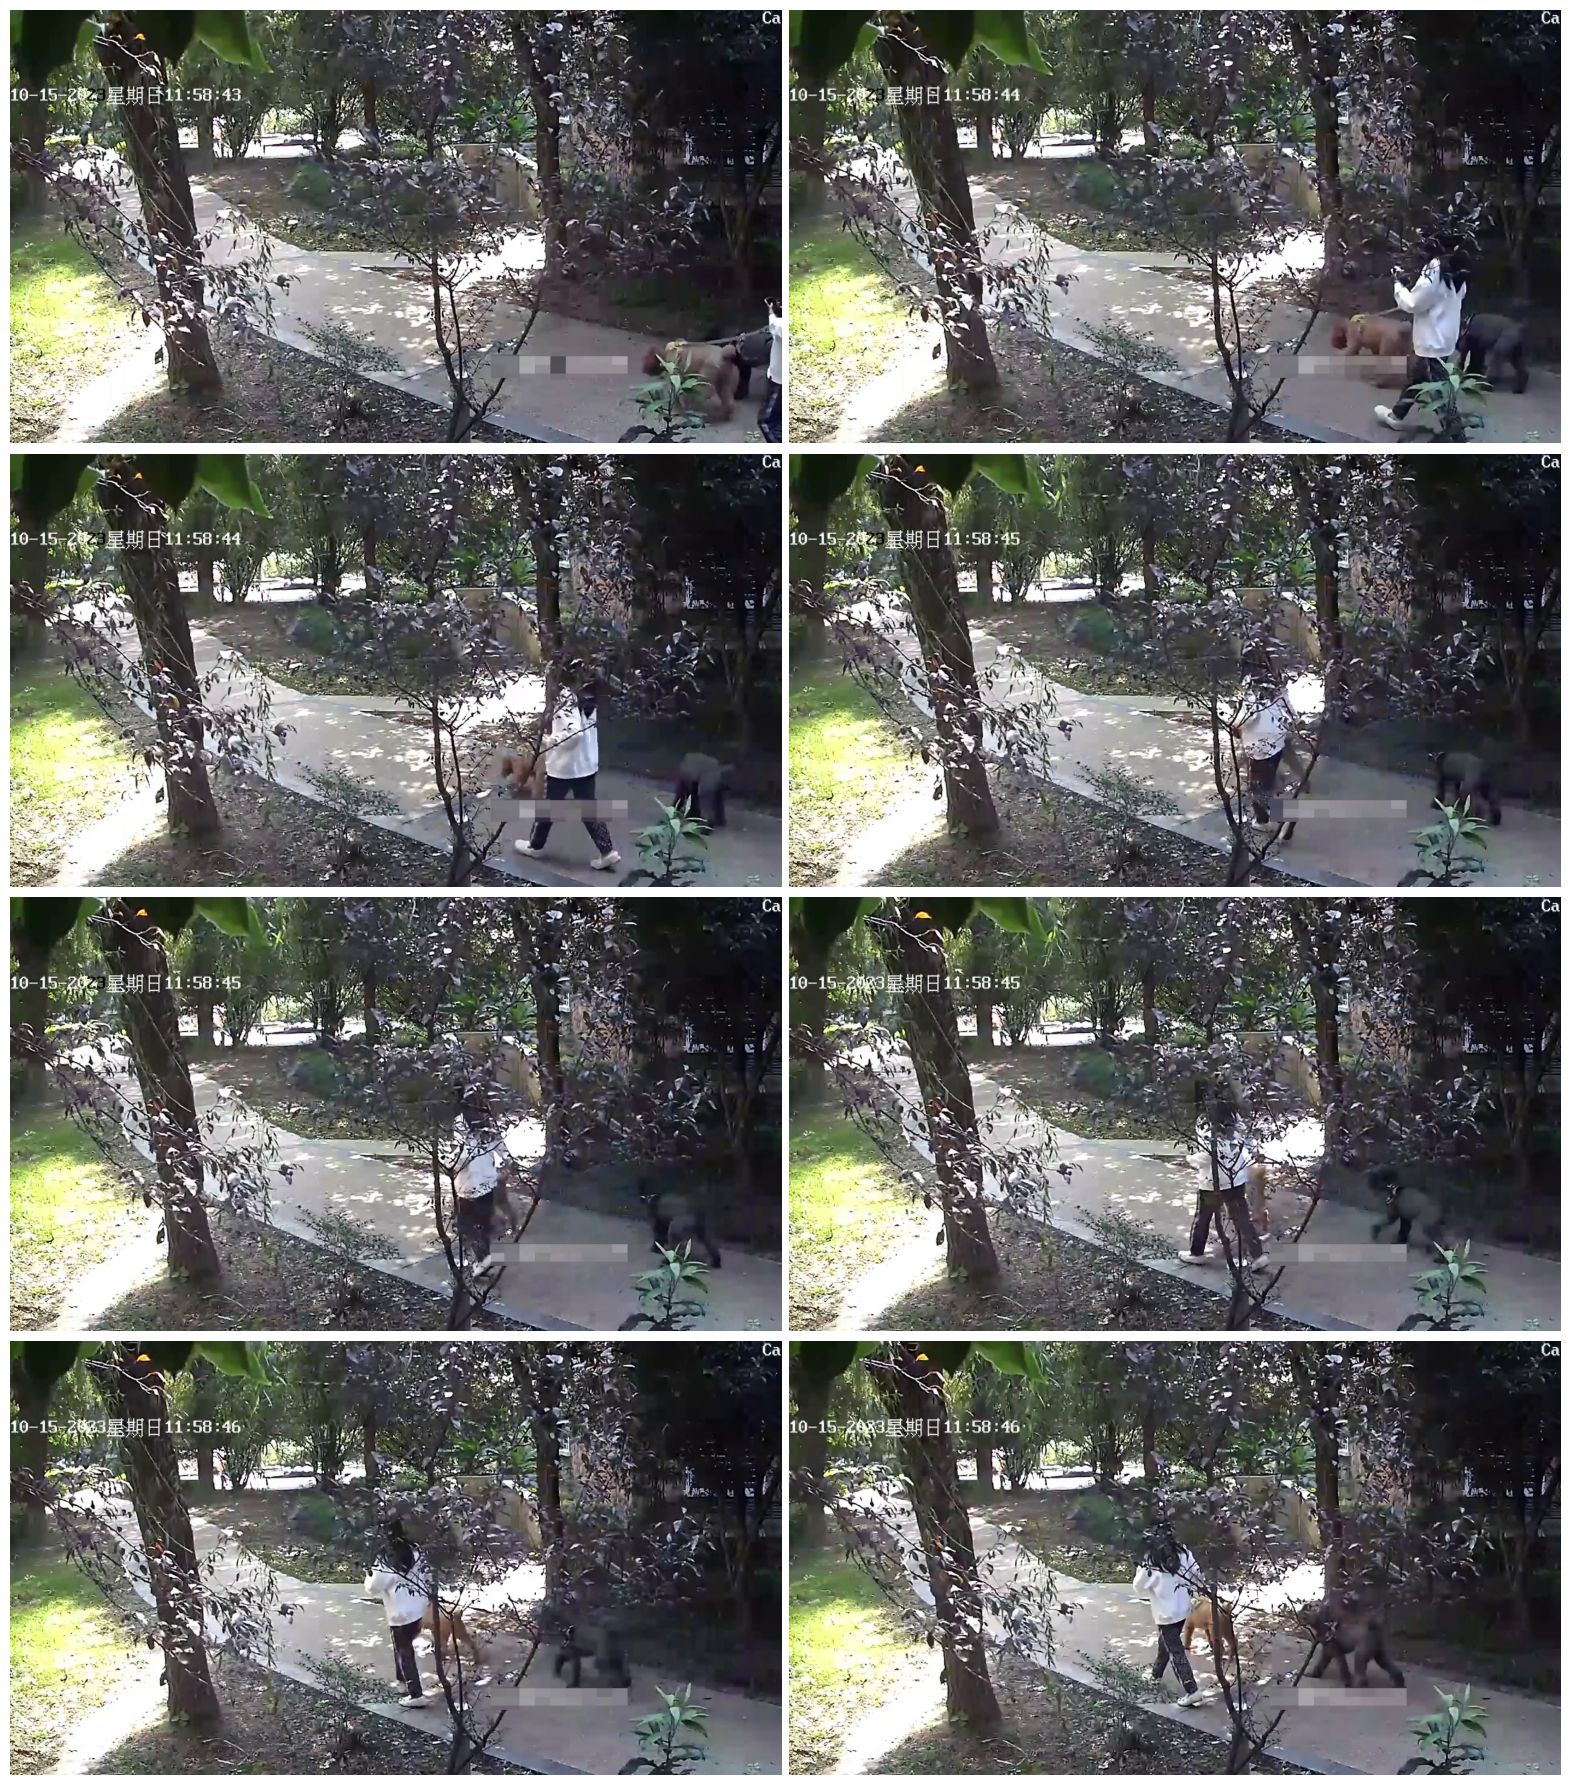

In [114]:
import random
import cv2
import numpy as np
from  matplotlib import pyplot as plt
%matplotlib inline

dest = "keyframe"  # 抽取图像保存路径
files = sorted([f for f in os.listdir(dest) if f.endswith('.png')])

# 随机展示连续 8 张图
start_idx = random.randint(0, len(files)-1)
end_idx = min(start_idx + 8, len(files))

plt.rcParams["figure.figsize"] = (20, 23)
plt.subplots_adjust(wspace=0.01,hspace=0.01)

for file_idx in range(start_idx, end_idx):
    plt.subplot(421 + file_idx - start_idx)
    plt.axis('off')
    img = cv2.imread(os.path.join(dest,files[file_idx]))
    plt.imshow(img[:,:,::-1])
    print(files[file_idx])

### 将抽帧生成的图片复制到 S3 桶中
用于数据标注

In [78]:
# 将抽帧图片复制到 S3 中
import boto3
import os
s3client = boto3.client("s3")
img_directory = "./keyframe/images"
files = os.listdir(img_directory)
for f in files:
    s3client.upload_file(os.path.join(img_directory, f), "search-bike-frame", f)
    print(f)

FileNotFoundError: [Errno 2] No such file or directory: './keyframe/images'

### 下载yolov7源码

In [1]:
!git clone https://github.com/WongKinYiu/yolov7

Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1197 (delta 2), reused 3 (delta 1), pack-reused 1191
Receiving objects: 100% (1197/1197), 74.23 MiB | 31.06 MiB/s, done.
Resolving deltas: 100% (517/517), done.


### 进入 yolov7 
文件夹后边有些代码需要在yolov7下执行，有些需要在notebook根目录执行，需要自行判断

In [17]:
%cd yolov7

/home/ec2-user/SageMaker/yolov7


### 安装yolov7依赖项

!pip install -r requirements.txt

### 验证yolov7功能是不是正常

In [7]:
!python detect.py --device cpu --no-trace

Namespace(weights='yolov7.pt', source='inference/images', img_size=640, conf_thres=0.25, iou_thres=0.45, device='cpu', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=True)
YOLOR 🚀 v0.1-128-ga207844 torch 2.0.1 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Model Summary: 306 layers, 36905341 parameters, 6652669 gradients
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1686274778240/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
4 persons, 1 bus, 1 tie, Done. (1546.2ms) Inference, (1.5ms) NMS
 The image with the result is 

### 将 AWS Ground Truth 的标注信息，转换为 yolov7 需要的格式（如果用VOTT标注，往下看）
1. 确保当前在 SageMaker 文件夹下
1. 使用 AWS Ground Truth 标注完成后，所有存放在S3中。其中标注信息是一个单独的文本文件 <br>
 比如:s3://search-bike-frame/search-bike-frame-bounding-box-job/manifests/output/output.manifest
2. 下面的代码会将 yolov7 的标注文件生成到 yolov7/datasets/labels，图片生成到 yolov7/datasets/images

In [28]:
import json
import os
import s3fs
import boto3


# 将 AWS 的标注 box 转换为 yolo 的标注 box
def convert_aws_to_yolo(size, aws_box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    # aws_box 的四个值分别是 top, left, height, width
    x = aws_box[1] + aws_box[3] / 2.0
    y = aws_box[0] + aws_box[2] / 2.0
    w = aws_box[3]
    h = aws_box[2]
    return (x*dw, y*dh, w*dw, h*dh)


# 创建用于存放 yolo 训练 图片 和 标注信息 的文件夹
def make_dataset_dir(parent_dir="./yolov7/datasets/"):
    dataset_dirs = []
    sub_dirs = ['images', 'labels']
    for d in sub_dirs:
        directory = os.path.join(parent_dir, d)
        dataset_dirs.append(directory)
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f'新建文件夹: {directory}')
        else:
            print(f'文件夹已存在: {directory}')
    print(f"dataset_dirs: {dataset_dirs}")  # 返回了一个字典
    return dataset_dirs[0], dataset_dirs[1]


# 把 s3 的 url 分割为 bucket 和 key 两部分
# 比如 s3://search-bike-frame/search-bike-frame-bounding-box-job/manifests/output/output.manifest
# 分割为 search-bike-frame
# 和 search-bike-frame-bounding-box-job/manifests/output/output.manifest
def split_s3_url(s3_url):
    items = s3_url.split('/', 3)
    return (items[2], items[3])


# 在 yolov7/datasets 下创建需要的 labels 和 images 文件夹
images_dir, labels_dir = make_dataset_dir()
s3client = boto3.client("s3")
# 通过s3fs，直接从 S3 打开通过 Amazon SageMaker Ground Truth 生成的标注文件
fs = s3fs.S3FileSystem()
# 这里指定 AWS Amazon SageMaker 生成标注文件位置 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
annotation_url = 's3://search-bike-frame/search-bike-frame-bounding-box-job/manifests/output/output.manifest'
aws_output_file = fs.open(annotation_url, encoding='UTF-8')
# AWS 一个文件的标注 就是一行
lines = aws_output_file.readlines()

# 统计计数 写入标注文件数量 和 标注总数量
file_count = 0
annotation_count = 0
for line in lines:
    json_result = json.loads(line)
    img_url = json_result['source-ref']
    img_bucket, img_key = split_s3_url(img_url)
    # 下载的目的文件
    img_path = os.path.join(images_dir, img_key)
    # 将图片从 S3 下载到 notebook 本地
    s3client.download_file(img_bucket, img_key, img_path)

    img_name = os.path.basename(img_url).split('.')[0]  # 移除路径和扩展名，只要文件名
    json_size = json_result['search-bike-frame-bounding-box-job']['image_size']
    size = (json_size[0]['width'], json_size[0]['height'])
    annotations = json_result['search-bike-frame-bounding-box-job']['annotations']
    with open(f'{labels_dir}/{img_name}.txt', 'w') as out_file:
        for item in annotations:
            class_id = item['class_id']
            aws_box = (item['top'], item['left'], item['height'], item['width'])
            yolo_box = convert_aws_to_yolo(size, aws_box)
            # 依次写入: class_id x y w h 换行符
            file_content = f"{class_id} {' '.join([str(i) for i in yolo_box])}\n"
            out_file.write(file_content)
            annotation_count += 1
    file_count += 1
    if file_count % 100 == 0:
        print(f'{file_count} / {len(lines)} ...')
print(f"写入标注文件数量:{file_count}, 标注总数量:{annotation_count}")



新建文件夹: ./yolov7/datasets/images
新建文件夹: ./yolov7/datasets/labels
dataset_dirs: ['./yolov7/datasets/images', './yolov7/datasets/labels']


KeyboardInterrupt: 

### 将 vott 的标注信息，转换为 yolov7 需要的格式（如果用 AWS Ground Truth 标注，往上看）
1. 确保当前在 SageMaker 文件夹下
1. vott 有导出功能，需要导出格式为 VoTT JSON, 会导出一个json文件，存放在存标签的文件夹下的"vott-json-export/XXX-export.json" <br>
1. 先使用 AWS CLI 将你在本地标注的文件和图片上传到 S3 中，我这里上传的位置是 S3://search-bike-frame2 <br>
比如：aws s3 cp ./batch01 s3://search-bike-frame2 --recursive 将本地batch01文件夹下的内容，全部都复制到s3的根目录
1. Amazon SageMaker 的标注信息是一个单独的文本文件，存放在s3中 
1. 比如:s3://search-bike-frame/search-bike-frame-bounding-box-job/manifests/output/output.manifest
1. yolov7需要的标注文件存放在文件夹中 yolov7/datasets/labels

In [2]:
import json
import os
import s3fs
import boto3
from botocore.exceptions import ClientError


# 将 VOTT 的标注 box 转换为 yolo 的标注 box
def convert_vott_to_yolo(size, aws_box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    # aws_box 的四个值分别是 top, left, height, width
    x = aws_box[1] + aws_box[3] / 2.0
    y = aws_box[0] + aws_box[2] / 2.0
    w = aws_box[3]
    h = aws_box[2]
    return (x*dw, y*dh, w*dw, h*dh)


# 创建用于存放 yolo 训练 图片 和 标注信息 的文件夹
def make_dataset_dir(parent_dir="./yolov7/datasets2/"):
    dataset_dirs = []
    sub_dirs = ['images', 'labels']
    for d in sub_dirs:
        directory = os.path.join(parent_dir, d)
        dataset_dirs.append(directory)
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f'新建文件夹: {directory}')
        else:
            print(f'文件夹已存在: {directory}')
    print(f"dataset_dirs: {dataset_dirs}")  # 返回了一个字典
    return dataset_dirs[0], dataset_dirs[1]


class_ids = {'Pedestrian': 0, 'Bike': 1}
img_bucket = "search-bike-frame2"  # 存放图片的桶
img_bucket_path = "imgs/"  # 图片在桶中的路径

# 在 yolov7/datasets 下创建需要的 labels 和 images 文件夹
images_dir, labels_dir = make_dataset_dir()
# s3client 用于从S3下载文件到 notebook
s3client = boto3.client("s3")
# 通过s3fs，直接从 S3 打开通过 Amazon SageMaker 生成的标注文件
fs = s3fs.S3FileSystem()
# 这里指定 AWS Amazon SageMaker 生成标注文件位置 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
annotation_url = 's3://search-bike-frame2/tags/vott-json-export/batch01-export.json'
aws_output_file = fs.open(annotation_url, encoding='UTF-8')
# AWS 一个文件的标注 就是一行
content = aws_output_file.read()
assets = json.loads(content)['assets']
file_count = 0
annotation_count = 0
for k, v in assets.items():
    size = (v['asset']['size']['width'], v['asset']['size']['height'])
    img_name = v['asset']['name'].split('.')[0]
    # 下载图片到本地
    try:
        s3client.download_file(img_bucket,
                               os.path.join(img_bucket_path, v['asset']['name']),
                               os.path.join(images_dir, v['asset']['name']))

        with open(f'{labels_dir}/{img_name}.txt', 'w') as out_file:
            for region in v['regions']:
                boundingBox = region['boundingBox']
                box = (boundingBox['top'], boundingBox['left'],
                       boundingBox['height'], boundingBox['width'])
                yolo_box = convert_vott_to_yolo(size, box)
                tag = region['tags'][0]
                file_content = f"{class_ids[tag]} {' '.join([str(i) for i in yolo_box])}\n"
                out_file.write(file_content)
                annotation_count += 1
        file_count += 1
        if file_count % 100 == 0:
            print(f'{file_count} / {len(assets)} ...')
    except ClientError as e:
        print(e)
        print(f"获取文件失败:{v['asset']['name']}")
print(f"写入标注文件数量:{file_count}, 标注总数量:{annotation_count}")

文件夹已存在: ./yolov7/datasets2/images
文件夹已存在: ./yolov7/datasets2/labels
dataset_dirs: ['./yolov7/datasets2/images', './yolov7/datasets2/labels']
100 / 2308 ...
200 / 2308 ...
300 / 2308 ...
400 / 2308 ...
500 / 2308 ...
600 / 2308 ...
700 / 2308 ...
800 / 2308 ...
900 / 2308 ...
1000 / 2308 ...
1100 / 2308 ...
1200 / 2308 ...
1300 / 2308 ...
1400 / 2308 ...
1500 / 2308 ...
1600 / 2308 ...
1700 / 2308 ...
An error occurred (404) when calling the HeadObject operation: Not Found
获取文件失败:ch04_20231018113552_047424.png
An error occurred (404) when calling the HeadObject operation: Not Found
获取文件失败:ch04_20231018113552_043752.png
An error occurred (404) when calling the HeadObject operation: Not Found
获取文件失败:ch04_20231018113552_043740.png
1800 / 2308 ...
1900 / 2308 ...
2000 / 2308 ...
2100 / 2308 ...
2200 / 2308 ...
2300 / 2308 ...
写入标注文件数量:2305, 标注总数量:2341


### 划分训练接和验证集
* 确保当前在 SageMaker 文件夹下
* 训练接和验证集 分别存放在'./yolov7/datasets/train.txt', './yolov7/datasets/val.txt'
* 这段逻辑是追加的逻辑, 将图片和标注文件, 复制到 datasets/images 和 datasets/labels 后，运行这段代码，新增的图片会按比例追加到训练接和验证集中，已有数据集数据不受影响

In [9]:
from random import sample
import os
import shutil


def create_file_set(path):
    file_set = set()
    if os.path.exists(path):
        with open(path, 'r') as f:
            lines = f.readlines()
            file_set = set([os.path.basename(line).strip() for line in lines])
    return file_set


# @@@@@@@@@ 根据数据集位置修改两个参数 @@@@@@@@@@@@@@@@@@@@
dataset_dir = "./yolov7/datasets2/"
line_path = "datasets2/images"

images_dir = os.path.join(dataset_dir, 'images/')
print(dataset_dir, images_dir)
images_list = [i for i in os.listdir(images_dir) if i.endswith('.png') or i.endswith('.jpg')]
images_total = len(images_list)


# 加载已经进入验证集和训练集的文件名，为了后边追加逻辑，这里先去重
val_set = create_file_set(os.path.join(dataset_dir, 'val.txt'))
train_set = create_file_set(os.path.join(dataset_dir, 'train.txt'))
# images_set 所有的图片，扣除已经进入 train.txt 和 val.txt 的文件，也就是本次需要新增的图片
images_set = set(images_list) - val_set - train_set
print(f'images文件夹共有图片: {images_total}。 其中训练集已包含: {len(train_set)}, 验证集已包含: {len(val_set)}')
print(f'本次新增图片数量: {len(images_set)}')


# 生成验证集(追加逻辑  验证集随机选择 15% 的图片)
val_images_list = set(sample(list(images_set), int(0.15 * len(images_set))))
line = ''
for item in val_images_list:
    line += f'{line_path}/{item}\n'
if line:
    with open(os.path.join(dataset_dir, 'val.txt'), 'a') as f:
        f.writelines(line)

# 剩下的生成训练集(追加逻辑)
line = ''
for item in images_set:
    if item not in val_images_list:
        line += f'{line_path}/{item}\n'
if line:
    with open(os.path.join(dataset_dir, 'train.txt'), 'a') as f:
        f.writelines(line)
print(f'本次新增训练集: {len(images_set - val_images_list)}, 新增验证集: {len(val_images_list)}')

./yolov7/datasets2/ ./yolov7/datasets2/images/
images文件夹共有图片: 2305。 其中训练集已包含: 1960, 验证集已包含: 345
本次新增图片数量: 0
本次新增训练集: 0, 新增验证集: 0


### 进入yolov7文件夹 （记清楚自己的位置，可能经常在两个文件夹切换）
* /home/ec2-user/SageMaker
* /home/ec2-user/SageMaker/yolov7

In [17]:
%cd yolov7

/home/ec2-user/SageMaker/yolov7


### 检查数据集，看看标注有没有问题

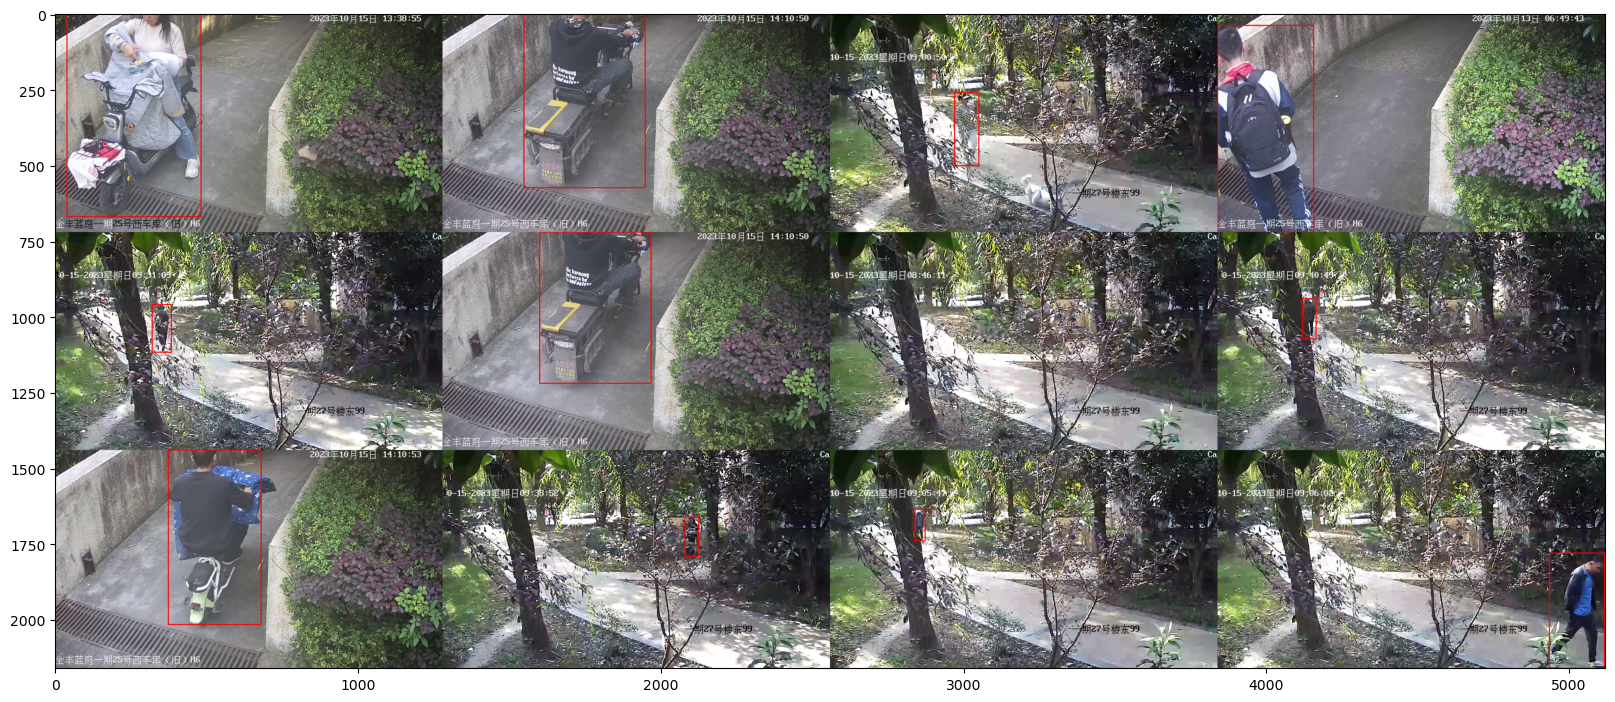

In [27]:
import random
import cv2
import numpy as np
from  matplotlib import pyplot as plt
%matplotlib inline

with open("datasets/train.txt", "r") as f:
    img_paths = f.readlines()

img_paths = random.sample(img_paths, 12)
img_lists = []

for img_path in img_paths:
    img_path = img_path.strip()
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    color = [0, 0, 255]
    # 标注文件名跟图片文件名，仅仅是扩展名不同
    label_file_path = img_path.replace("images", "labels")\
        .replace(".png", ".txt")\
        .replace(".jpeg", ".txt")
    with open(label_file_path) as f:
        labels = f.readlines()
    for label in labels:
        l, x, y, wc, hc = [float(x) for x in label.strip().split()]
        cv2.rectangle(img, (int((x - wc / 2) * w), int((y - hc / 2) * h)),
                      (int((x + wc / 2) * w), int((y + hc / 2) * h)),
                      color, thickness=4, lineType=cv2.LINE_AA)
    img_lists.append(cv2.resize(img, (1280, 720)))

image = np.concatenate([
    np.concatenate(img_lists[:4], axis=1),
    np.concatenate(img_lists[4:8], axis=1),
    np.concatenate(img_lists[8:], axis=1)],
    axis=0)

plt.rcParams["figure.figsize"] = (20, 10)
plt.imshow(image[:, :, ::-1])
plt.show()

### 下载预训练数据集

In [ ]:
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

### 查看磁盘空间是否足够

In [ ]:
!df -h

### 开始训练模型

In [ ]:
!python train.py --weights yolov7_training.pt --batch-size 10 --epochs 240 --name searchbike --multi-scale --device 0

YOLOR 🚀 v0.1-128-ga207844 torch 2.0.1 CUDA:0 (Tesla T4, 15102.0625MB)

Namespace(weights='yolov7.pt', cfg='cfg/training/yolov7.yaml', data='data/bike.yaml', hyp='data/hyp.scratch.p5.yaml', epochs=240, batch_size=10, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=True, single_cls=False, adam=False, sync_bn=True, local_rank=-1, workers=8, project='runs/train', entity=None, name='c-320', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], v5_metric=False, world_size=1, global_rank=-1, save_dir='runs/train/c-32010', total_batch_size=10)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_l

In [ ]:
!pip install tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 4.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 4.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 41.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 44.8 MB/s eta 0:00:00


In [41]:
!protoc --version

libprotoc 3.21.12


In [42]:
!pip install protobuf==3.20.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:0000:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4


### 更改数据集分辨率
太高分辨率 不利于训练

In [ ]:
import os
import cv2

dataset_dir = './yolov7/datasets2/'
small_img_dir = os.path.join(dataset_dir, 'images_small/')
if not os.path.exists(small_img_dir):
    os.mkdir(small_img_dir)
px1920 = 0
px1280 = 0
pxother = 0
for file_name in os.listdir(os.path.join(dataset_dir, 'images/')):
    if not file_name.endswith(('.png', '.jpg', '.jpeg')):
        break
    file_path = os.path.join(dataset_dir, 'images/', file_name)
    img = cv2.imread(file_path)
    h, w, c = img.shape
    if w >= 1920:
        img = cv2.resize(img, None, fx=1/3, fy=1/3, interpolation = cv2.INTER_AREA)
        px1920 += 1
    elif w >= 1280:
        img = cv2.resize(img, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_AREA)
        px1280 += 1
    else:
        pxother += 1
    cv2.imwrite(os.path.join(small_img_dir, file_name), img)
    if (px1920+px1280+pxother) % 100 == 0:
        print(f'1920:{px1920}, 1280:{px1280}, other:{pxother} ...')
print(f'Done! 1920:{px1920}, 1280:{px1280}, other:{pxother}')